# Compare the autoencoder vs the encode-decoder

Somehow the pickeled autoencoder model is about 3 times larger than the pickeled encoder and decoder model together. If the result of the autoencoder is the same as the encoder followed by the decoder then we don't need to save the autoencoder at all.

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

assembly = 'hg19'
window_size = 12000
step_size = window_size / 2
aggregation = 100
chroms = ['chr22']

## Load and normalize the data

#### Download the data

In [4]:
import wget
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True) 

print('Download data...')

# GM12878 DNase-seq read-depth normalized signal
bw = 'data/ENCFF158GBQ.bigWig'
if not Path(bw).is_file():
    wget.download(
        'https://www.encodeproject.org/files/ENCFF158GBQ/@@download/ENCFF158GBQ.bigWig',
        'data/ENCFF158GBQ.bigWig',
    )

print('Done!')

Download data...
Done!


#### Extract genomic windows

In [5]:
"""Chunk up the bigWig file"""

from ae import bigwig

data = bigwig.chunk(
    bw,
    window_size,
    step_size,
    aggregation,
    chroms,
    verbose=True,
)[0]

Chrom: chr22 # win: 8550 Max:   21.434190273284912


#### Then, cap the data at the 99.9th percentile and normalize it to `[0,1]`

In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

cutoff = np.percentile(data, (0, 99.9))
data_norm = np.copy(data)
data_norm[np.where(data_norm < cutoff[0])] = cutoff[0]
data_norm[np.where(data_norm > cutoff[1])] = cutoff[1]

data_norm = MinMaxScaler().fit_transform(data_norm)

## Import the models

In [8]:
import keras

en = keras.models.load_model("../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-encoder-dcae.h5")
de = keras.models.load_model("../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-decoder-dcae.h5")
ae = keras.models.load_model("../data/models/encode-gm12878-chip-seq-h3k27ac-pval-2011-autoencoder-dcae.h5")

Using TensorFlow backend.


## Encode an example window

Encode an example using the encoder+decoder and the autoencoder and test the equality of the output:

In [9]:
window_id = 5920

data_test = data_norm[window_id].reshape(1, data_norm[window_id].shape[0], 1)

encoded = en.predict(data_test)
decoded = np.squeeze(de.predict(encoded))

autoencoded = np.squeeze(ae.predict(data_test))

print('The encoder+decoder and autoencoder outputs are equal: {}'.format(np.array_equal(decoded, autoencoded)))

The encoder+decoder and autoencoder outputs are equal: True


## Visualize the example window and encodings

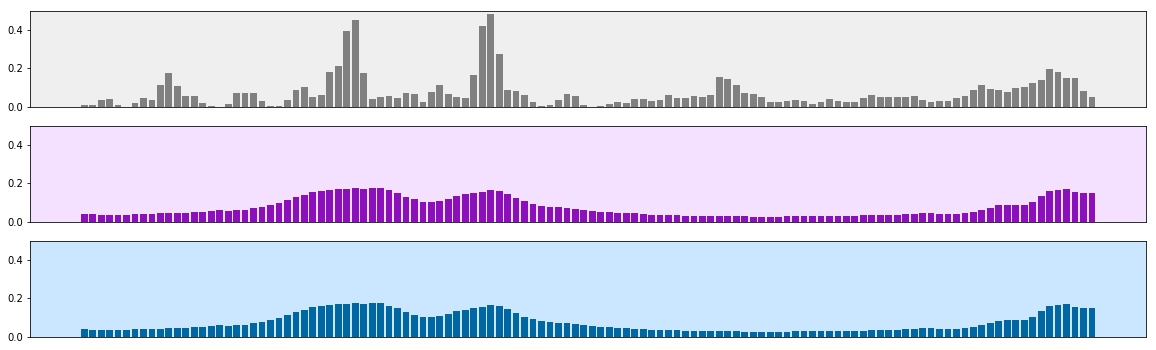

In [10]:
import matplotlib.pyplot as plt

ymax = 0.5

X = np.arange(data_norm[window_id].size)

plt.figure(figsize=(20, 6))
    
# display original
ax = plt.subplot(3, 1, 1)
ax.set_facecolor('#efefef')
plt.bar(X, data_norm[window_id], color='gray')
plt.ylim(0, ymax)
ax.get_xaxis().set_visible(False)

# display reconstruction
ax = plt.subplot(3, 1, 2)
ax.set_facecolor('#F3E1FF')
plt.bar(X, decoded, color='#8B10BB')
plt.ylim(0, ymax)
ax.get_xaxis().set_visible(False)

# display reconstruction
ax = plt.subplot(3, 1, 3)
ax.set_facecolor('#CBE6FF')
plt.bar(X, autoencoded, color='#0067A3')
plt.ylim(0, ymax)
ax.get_xaxis().set_visible(False)

plt.show()